In [1]:
from pmotifs.config import config

In [2]:
from pathlib import Path



ANALYSIS_CANDIDATES = {
    "yeast": {
        "edgelist": config.DATASET_DIRECTORY /  "yeastInter_st.txt",
        "outpath": config.EXPERIMENT_OUT / "pmotif_detection",
    },
}

In [3]:
CANDIDATE = "yeast"

GRAPH_EDGELIST = ANALYSIS_CANDIDATES[CANDIDATE]["edgelist"]
OUT = ANALYSIS_CANDIDATES[CANDIDATE]["outpath"]
GRAPHLET_SIZE = 3

In [4]:
# Retrieve Graphlets and their metrics
from pmotifs.PMotifGraph import PMotifGraph


g = PMotifGraph(GRAPH_EDGELIST, OUT)

In [5]:
g_p = g.load_graphlet_pos_zip(GRAPHLET_SIZE)

Load Graphlet Positions: 100%|████████| 13150/13150 [00:00<00:00, 160685.85it/s]


In [6]:
g_pm = g.load_positional_data(GRAPHLET_SIZE)

Loading Graphlet Metrics: 100%|███████| 13150/13150 [00:00<00:00, 154365.92it/s]


In [7]:
graphlet_lookup = dict(zip(g_p, g_pm.graphlet_metrics))

In [8]:
import pandas as pd

df = pd.DataFrame([
    {**k.__dict__, **v.__dict__}
    for k,v in graphlet_lookup.items()
])
df.head()

,graphlet_class,nodes,degree,anchor_node_distances,graph_module_participation
0,011 100 100,"[1, 199, 352]",10,"[4, 3, 2, 1, 2, 5, 2, 3, 4, 4, 3, 2, 3, 2, 3, ...",[0]
1,011 100 100,"[1, 199, 203]",8,"[4, 3, 3, 1, 2, 4, 1, 4, 4, 3, 4, 3, 3, 3, 3, ...","[0, 10]"
2,011 100 100,"[1, 199, 200]",9,"[3, 3, 3, 1, 1, 4, 1, 3, 4, 3, 3, 3, 3, 3, 3, ...","[0, 10]"
3,011 100 100,"[1, 199, 198]",11,"[3, 2, 2, 1, 2, 4, 1, 3, 3, 3, 3, 2, 3, 2, 3, ...",[0]
4,011 100 100,"[1, 199, 197]",17,"[3, 2, 2, 0, 2, 4, 1, 3, 3, 3, 3, 2, 2, 2, 2, ...",[0]


In [9]:
graphlet_classes = set(df["graphlet_class"])
graphlet_classes

{'011 100 100', '011 101 110'}

# Graphlet Occurrence Choice

In [10]:
CHOICE = df.iloc[10110]["nodes"]
CHOICE

['354', '578', '556']

In [11]:
chosen_occurrence = df[df["nodes"].isin([CHOICE])]
assert len(chosen_occurrence) == 1, "CHOICE does not specify exactly one row!"

# Analysis

In [12]:
chosen_occurrence

,graphlet_class,nodes,degree,anchor_node_distances,graph_module_participation
10110,011 100 100,"[354, 578, 556]",113,"[4, 5, 3, 3, 4, 4, 3, 4, 4, 4, 4, 3, 2, 3, 3, ...",[3]


In [13]:
METRIC_NAME = "degree"

metrics = df[METRIC_NAME].astype(float)
pivot = float(chosen_occurrence[METRIC_NAME])

below = []
above = []
for e in metrics:
    if e < pivot:
        below.append(e)
    elif e > pivot:
        above.append(e)

total = len(below) + len(above)
below_percent = (len(below) / total) * 100
above_percent = (len(above) / total) * 100
print(
    f"{CHOICE} has " + 
    f"higher {METRIC_NAME} than {round(below_percent, 2)}% and " + 
    f"lower {METRIC_NAME} than {round(above_percent, 2)}% of occurrences!"
)

['354', '578', '556'] has higher degree than 99.94% and lower degree than 0.06% of occurrences!


In [14]:
"""Tukey Method"""
from scipy.stats import iqr
from scipy.stats.mstats import mquantiles

q1, q2, q3 = mquantiles(metrics)
inner_quantile_range = iqr(metrics)

lower_outlier_cut = q1 - 1.5 * inner_quantile_range
upper_outlier_cut = q3 + 1.5 * inner_quantile_range

print(f"Outliers: x < {lower_outlier_cut}, {upper_outlier_cut} > x")

call = ""
if pivot < lower_outlier_cut:
    call = "lower"
if pivot > upper_outlier_cut:
    call = "upper"

if call != "":
    print(f"{CHOICE}({pivot}) is an {call} outlier!")

Outliers: x < -17.0, 95.0 > x
['354', '578', '556'](113.0) is an upper outlier!


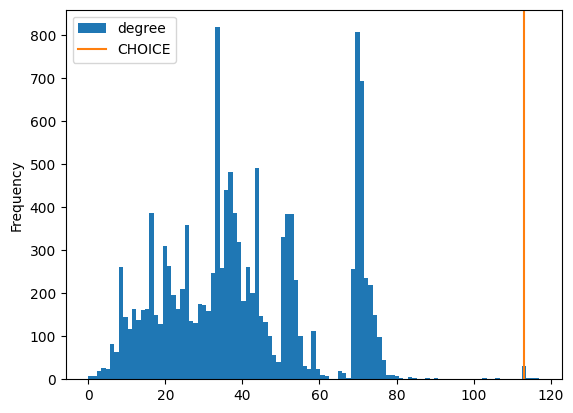

In [26]:
import matplotlib.pyplot as plt

frequency_of_pivot = df[df[METRIC_NAME] == pivot][METRIC_NAME].count()

fig, ax = plt.subplots(1, 1)
bars = df.plot.hist(bins=len(set(df[METRIC_NAME])), ax=ax)
ax.axvline(
    pivot,
    label="CHOICE",
    color="tab:orange",
)

ax.legend()

In [16]:
import networkx as nx

def prepare_kamada_kawai_layout_with_multiple_components(nx_g):
    pos_df = pd.DataFrame(index=nx_g.nodes(), columns=nx_g.nodes())
    max_dist = -1
    for row, data in nx.shortest_path_length(nx_g):
        for col, dist in data.items():
            pos_df.loc[row,col] = dist
            max_dist = max(max_dist, dist)

    pos_df = pos_df.fillna(max_dist / 2 + 2)

    return nx.kamada_kawai_layout(nx_g, dist=pos_df.to_dict())

In [67]:
"""Prepare Graph Plotting"""
import networkx as nx

nx_g = g.load_graph()
pos = prepare_kamada_kawai_layout_with_multiple_components(nx_g)

In [18]:
def highlight_motif(nx_g, motif, ax, pos):
    subgraph = nx.induced_subgraph(nx_g, motif)

    nx.draw_networkx_nodes(
        nx_g,
        nodelist=subgraph.nodes,
        node_color='r',
        pos=pos,
        ax=ax,
        node_size=20,
    )
    nx.draw_networkx_labels(
        nx_g,
        labels={node: node for node in subgraph.nodes},
        pos=pos,
        ax=ax,
        font_size=6,
        font_color='b',
    )
    nx.draw_networkx_edges(
        nx_g,
        pos=pos,
        edgelist=subgraph.edges,
        ax=ax,
        edge_color="r",
    )

In [19]:
def plot_graph_with_motif_highlight(nx_g, motifs, pos, ax, title=""):
    nx.draw(nx_g, pos=pos, ax=ax, node_size=20)

    for m in motifs:
        highlight_motif(nx_g, m, ax, pos)

    ax.set_title(title)

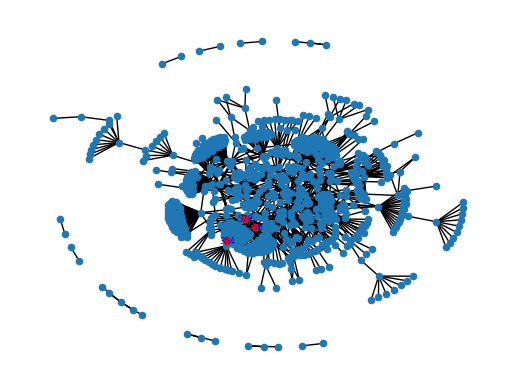

In [20]:
fig, ax = plt.subplots(1,1)
plot_graph_with_motif_highlight(nx_g, list(chosen_occurrence.nodes), pos, ax)

In [74]:
def get_zommed_graph(nx_g, nodes, node_range=3):
    relevant_nodes = []
    for n in nodes:
        neighbors = nx.descendants_at_distance(nx_g, n, node_range)
        relevant_nodes.extend(neighbors)
        relevant_nodes.append(n)
    
    subgraph = nx.induced_subgraph(nx_g, relevant_nodes)
    
    return subgraph
    

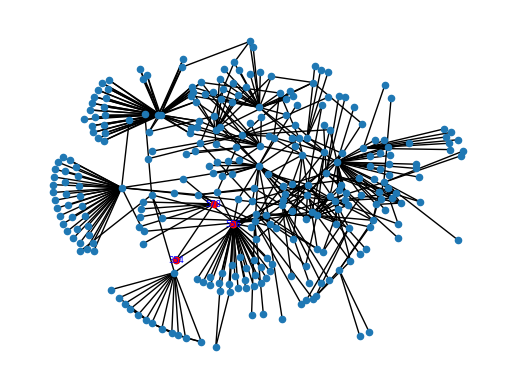

In [76]:
fig, ax = plt.subplots(1,1)
plot_graph_with_motif_highlight(
    get_zommed_graph(nx_g, chosen_occurrence["nodes"].values[0]),
    chosen_occurrence["nodes"].values[0],
    pos,
    ax,
)